In [8]:
import modules
import math
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import plotly.express as px
import agama
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.units import Quantity
from astroquery.gaia import Gaia


import plotly.graph_objects as go
from plotly.subplots import make_subplots

plt.rcParams['figure.figsize']=(16.,9.)

In [9]:
#from astroquery.gaia import Gaia
#Gaia.login()

#https://ui.adsabs.harvard.edu/abs/2018ApJ...860L..11K/abstract
#https://ui.adsabs.harvard.edu/abs/2019A%26A...625A...5K/abstract
#https://gea.esac.esa.int/archive/

In [10]:
ra = 230.29273250927704
dec=-6.132573862818884

In [11]:
# Set the coordinates for the main star

ra = 230.29273250927704
dec=-6.132573862818884

# Request the start in the radious r around the main star

Jessicas_star = modules.get_stars (ra,dec, 0.19)
Jessicas_star

source_id,ra,ra_error,dec,dec_error,pmra,pmdec,parallax,parallax_error,phot_g_mean_mag,bp_rp,dr2_radial_velocity,dr2_radial_velocity_error
,deg,mas,deg,mas,mas / yr,mas / yr,mas,mas,mag,mag,km / s,km / s
int64,float64,float32,float64,float32,float64,float64,float64,float32,float32,float32,float32,float32
6322618921196687616,230.37303366367576,0.013362186,-6.29040887816419,0.010318823,0.7187193126073992,-4.1259360020886025,0.13752199962081071,0.014719714,13.301006,1.2827702,-31.164396,2.2962618
6322785222330165376,230.21948492086358,0.014321192,-6.2413327763229285,0.011496288,-8.666549135064905,-20.121912105117584,2.699252786984693,0.016399221,12.628043,0.9856758,-34.734783,12.076377
6322811163932641152,230.292731068023,0.013537873,-6.132579401460333,0.010995768,-10.386058567584058,-39.71009932590997,0.46414759892824425,0.014991589,10.777189,1.2218094,-12.034008,0.54493254
6322811610609237120,230.40112941797062,0.014668548,-6.090961739371799,0.012445117,-11.550303272165191,-1.5508344889953816,0.43026014693363324,0.016405314,11.362554,1.2531433,12.037468,0.55603325
6322821025177561472,230.37716155003025,0.0137101365,-6.006247845686546,0.011247317,-53.85179879330579,0.683257182489821,3.5713932766366208,0.014668231,11.978758,0.9843483,-60.10393,0.6849746


In [12]:
# Use gal_uvw to calculate velocities 

U = []
V = []
W = []

for i in Jessicas_star:
    u, v, w = modules.gal_uvw(ra = i["ra"], dec = i["dec"], pmra = i["pmra"] , pmdec = i["pmdec"], vrad = i["dr2_radial_velocity"], plx = i["parallax"], lsr='yes')
    U.append(u)
    V.append(v)
    W.append(w)

#V = np.array(V) - [220] * len(V) #local standart of rest

T = np.sqrt(np.array(U)**2+np.array(W)**2)


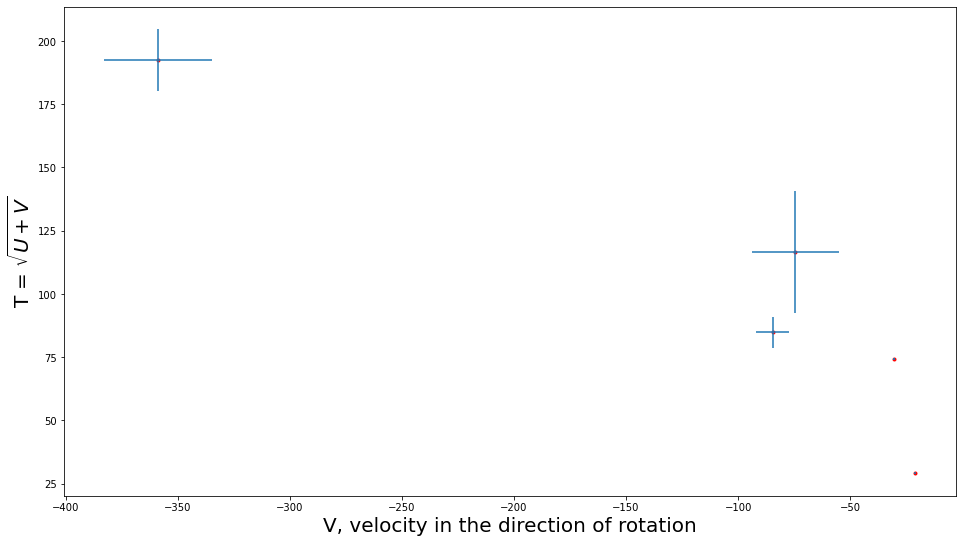

In [13]:
# Calculate error bars / re-run modules.gal_uvw with (parallax - parralax-error) and (parallax + parralax-error)
plx_lower = Jessicas_star["parallax"] - Jessicas_star["parallax_error"]
plx_upper = Jessicas_star["parallax"] + Jessicas_star["parallax_error"]

   
U_upper = []
V_upper = []
W_upper = []


for i in Jessicas_star:
    plx = i["parallax"] - i["parallax_error"]
    u, v, w = modules.gal_uvw(ra = i["ra"], dec = i["dec"], pmra = i["pmra"] , pmdec = i["pmdec"], vrad = i["dr2_radial_velocity"], plx = plx , lsr='yes')
    U_upper.append(u)
    V_upper.append(v)
    W_upper.append(w)
    
    
V_upper = np.array(V_upper) - [220] * len(V) #local standart of rest

T_upper = np.sqrt(np.array(U_upper)**2+np.array(W_upper)**2)


U_lower = []
V_lower = []
W_lower = []


for i in Jessicas_star:
    plx = i["parallax"] + i["parallax_error"]
    u, v, w = modules.gal_uvw(ra = i["ra"], dec = i["dec"], pmra = i["pmra"] , pmdec = i["pmdec"], vrad = i["dr2_radial_velocity"], plx = plx , lsr='yes')
    U_lower.append(u)
    V_lower.append(v)
    W_lower.append(w)
    
    
V_lower = np.array(V_lower) - [220] * len(V) #local standart of rest

T_lower = np.sqrt(np.array(U_lower)**2+np.array(W_lower)**2)

xerr = V_upper - V_lower
yerr = T_upper - T_lower

plt.scatter(V, T, marker='.', color='r')


plt.errorbar(V, T, xerr=xerr,yerr=yerr, linestyle="None")

plt.xlabel('V, velocity in the direction of rotation', fontsize=20)
plt.ylabel( r'T = $\sqrt{U + V}$', fontsize=20)

plt.show()



In [14]:
# Query Halo Stars

halo_stars = modules.get_halo_stars (10)

df_halo_stars = halo_stars.to_pandas()

#Apply gal_uvw

df_halo_stars["uvw"] = df_halo_stars.apply( \
        lambda row: \
            modules.gal_uvw( \
                row["ra"], \
                row["dec"], \
                row["dec"], \
                row["pmra"], \
                row["pmdec"], \
                row["dr2_radial_velocity"], \
                row["parallax"] \
            ), \
        axis=1 \
    )

#Calculate T

df_halo_stars["T"] = df_halo_stars.apply( \
        lambda row: np.sqrt(row['uvw'][0]**2+row['uvw'][2]**2),
        axis=1 \
    )

#Append values to the dataset 

df_halo_stars[['U', 'V', 'W']] = pd.DataFrame(df_halo_stars['uvw'].tolist(), index=df_halo_stars.index)

#Isolate based on velocity (cut out circle)

df_halo_stars["V-232"] = df_halo_stars.apply( \
        lambda row: abs(row['V'] - 232),
        axis=1 \
    )

df_halo_stars = df_halo_stars[df_halo_stars["V-232"]**2 + df_halo_stars["T"]**2 > 210**2]


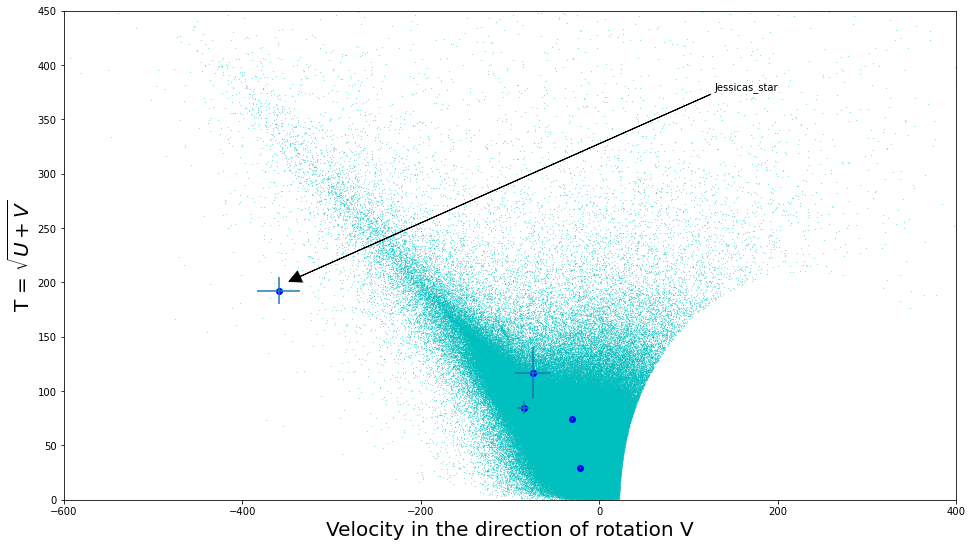

In [22]:
#plt.scatter(df1['vy']+220, t1, color='c',  s = 0.1)
plt.scatter(df_halo_stars['V'], df_halo_stars['T'], color='c',  s = 0.03)
plt.scatter(V, T, color='b')

plt.scatter(V, T, color='b', s = 0.01)


plt.errorbar(V, T, xerr=xerr,yerr=yerr, linestyle="None")

plt.annotate('Jessicas_star', xy=(-350, 200),  xycoords='data',
            xytext=(0.8, 0.85), textcoords='figure fraction',
            arrowprops=dict(facecolor='black', shrink=0.005, width = 0.005),
            horizontalalignment='right', verticalalignment='top',
            )

plt.xlabel('Velocity in the direction of rotation V', fontsize=20)
plt.ylabel( r'T = $\sqrt{U^2 + V^2}$', fontsize=20)

plt.xlim(-600,  400)
plt.ylim(0, 450)
plt.show()